In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd

import json
import glob
import os
import re

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
base = "../exp/"
sizes = [int(f) for f in os.listdir(base + 'compression')]
datasets = { num: [json.load(open(path)) for path in glob.glob(base + f"compression/{num}/*.json") + glob.glob(base + f"compression_1h/{num}/*.json")] for num in sizes }

In [3]:
queries = pd.DataFrame.from_records([{
    **algo,
    'potential': run['potential'],
    'graph': run['args'][1],
    'queryset': run['args'][2],
    'num_metrics': num_metrics,
} for (num_metrics, data) in datasets.items() for run in data for algo in run['algo_runs']])

In [4]:
paths = glob.glob(base + "rand/*.json") + glob.glob(base + "1h/*.json")
data = [json.load(open(path)) for path in paths]
queries_uncompressed = pd.DataFrame.from_records([{
    **algo,
    'potential': run['potential'],
    'graph': run['args'][1],
    'queryset': run['args'][2],
    'topo': 'no_topo' not in run['program'],
} for run in data for algo in run['algo_runs']]).query('topo')

In [61]:
merged = queries.merge(queries_uncompressed, how='left', on=['graph', 'potential', 'from', 'to', 'at'], suffixes=[None, '_uncompressed'])

In [62]:
merged['slowdown'] = merged['running_time_ms'] / merged['running_time_ms_uncompressed']

<AxesSubplot:xlabel='num_metrics', ylabel='slowdown'>

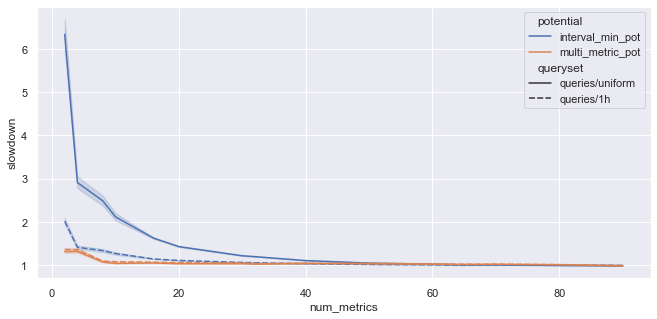

In [7]:
plt.figure(figsize=(11,5))
sns.lineplot(data=merged.loc[lambda x: x['graph'].str.contains('osm')], x='num_metrics', y='slowdown', hue='potential', style='queryset')

<AxesSubplot:xlabel='num_metrics', ylabel='slowdown'>

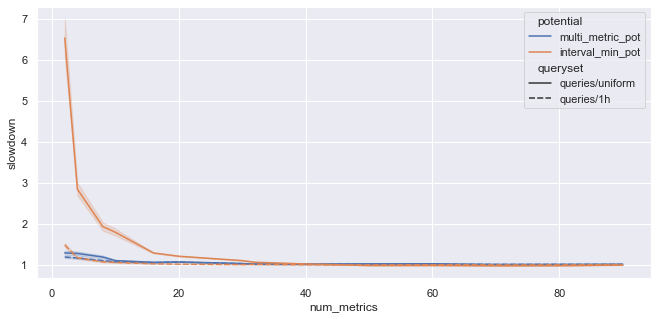

In [8]:
plt.figure(figsize=(11,5))
sns.lineplot(data=merged.loc[lambda x: x['graph'].str.contains('ptv')], x='num_metrics', y='slowdown', hue='potential', style='queryset')

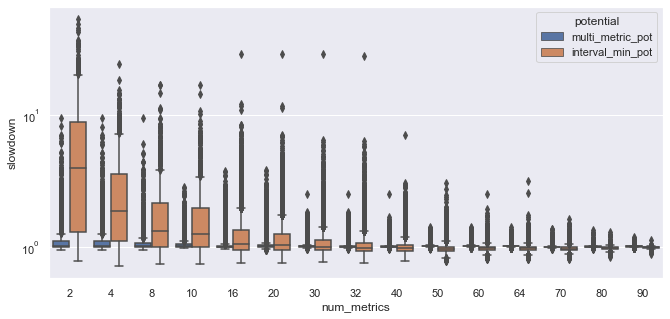

In [19]:
plt.figure(figsize=(11,5))
g = sns.boxplot(data=merged.loc[lambda x: x['graph'].str.contains('ptv')].query('queryset == "queries/uniform"'), x='num_metrics', y='slowdown', hue='potential')
g.set_yscale('log')

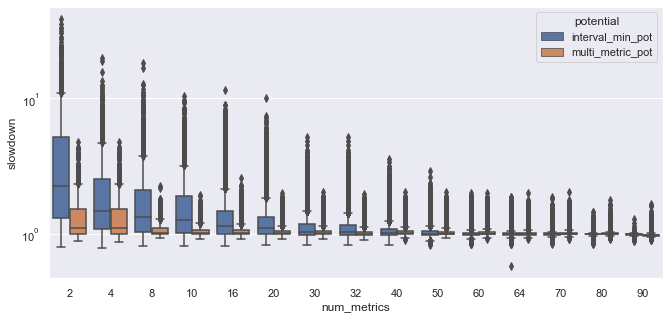

In [23]:
plt.figure(figsize=(11,5))
g = sns.boxplot(data=merged.loc[lambda x: x['graph'].str.contains('osm')], x='num_metrics', y='slowdown', hue='potential')
g.set_yscale('log')

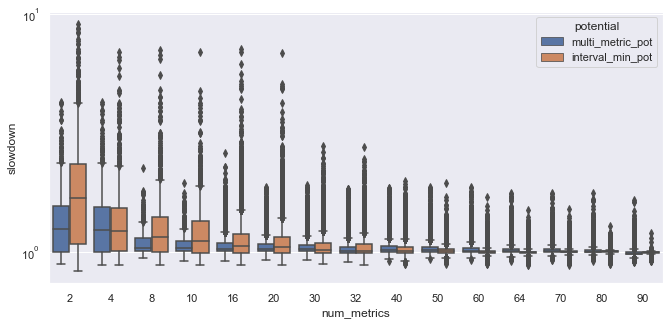

In [21]:
plt.figure(figsize=(11,5))
g = sns.boxplot(data=merged.loc[lambda x: x['graph'].str.contains('osm')].query('queryset == "queries/1h"'), x='num_metrics', y='slowdown', hue='potential')
g.set_yscale('log')

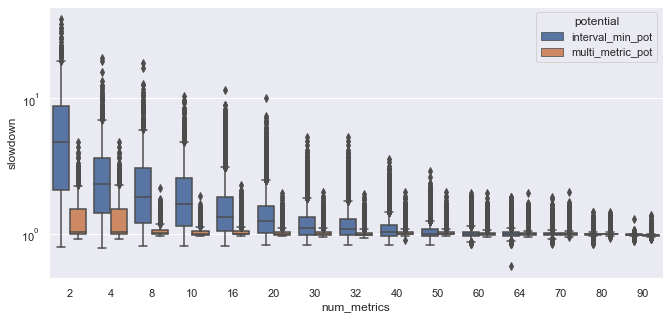

In [22]:
plt.figure(figsize=(11,5))
g = sns.boxplot(data=merged.loc[lambda x: x['graph'].str.contains('osm')].query('queryset == "queries/uniform"'), x='num_metrics', y='slowdown', hue='potential')
g.set_yscale('log')

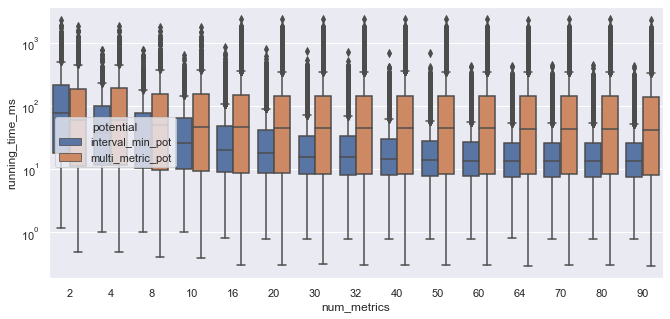

In [10]:
plt.figure(figsize=(11,5))
g=sns.boxplot(data=queries.loc[lambda x: x['graph'].str.contains('osm')].query('queryset == "queries/uniform"'), x='num_metrics', y='running_time_ms', hue='potential')
g.set_yscale('log')
#sns.lineplot(data=queries.loc[lambda x: x['graph'].str.contains('osm')], x='num_metrics', y='running_time_ms', hue='potential', style='queryset')

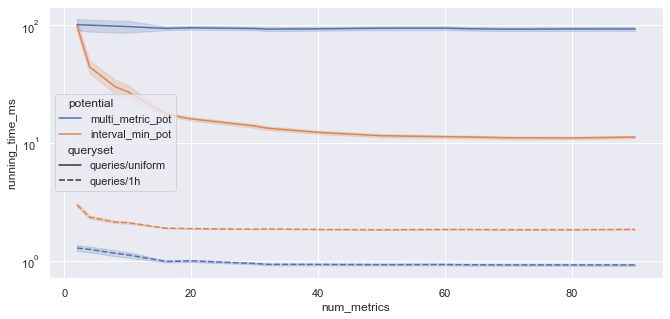

In [11]:
plt.figure(figsize=(11,5))
g = sns.lineplot(data=queries.loc[lambda x: x['graph'].str.contains('ptv')], x='num_metrics', y='running_time_ms', hue='potential', style='queryset')
g.set_yscale('log')

In [12]:
queries_uncompressed.query('queryset == "queries/1h"').loc[lambda x: x['graph'].str.contains('ptv')].groupby('potential')['running_time_ms'].describe()

,count,mean,std,min,25%,50%,75%,max
potential,,,,,,,,
interval_min_pot,10000.00,1.86,0.75,0.72,1.49,1.83,2.14,54.05
lower_bound_cch_pot,10000.00,1.28,1.57,0.18,0.50,0.73,1.47,28.00
multi_metric_pot,10000.00,0.92,0.88,0.18,0.53,0.68,0.99,18.21


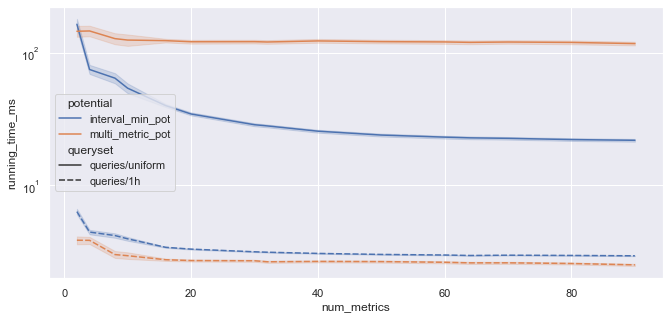

In [13]:
plt.figure(figsize=(11,5))
g = sns.lineplot(data=queries.loc[lambda x: x['graph'].str.contains('osm')], x='num_metrics', y='running_time_ms', hue='potential', style='queryset')
g.set_yscale('log')

In [64]:
merged['potential'] = merged['potential'].map({ 'multi_metric_pot': 'MMP', 'interval_min_pot': 'IMP' })
merged['queryset'] = merged['queryset'].map({ 'queries/uniform': 'Random', 'queries/1h': '1h' })
merged = merged.rename(columns={ 'queryset': 'Queries', 'potential': 'Potential' })

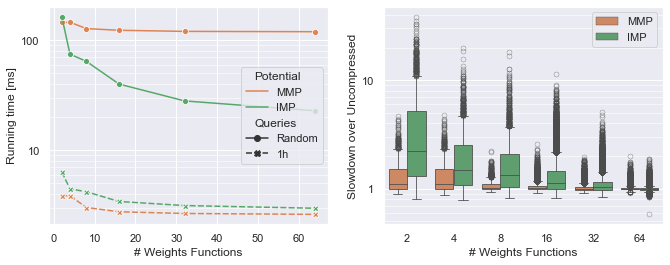

In [71]:
queries_sub = merged.loc[lambda x: x['graph'].str.contains('osm') & (x['num_metrics'] % 10 != 0)]
queries_sub

fig, axs = plt.subplots(1, 2, figsize=(11,4))
g = sns.lineplot(data=queries_sub, x='num_metrics', y='running_time_ms', hue='Potential', style='Queries', ax=axs[0], ci=None, palette=['C1', 'C2'], hue_order=['MMP', 'IMP'], markers=True)
g.set_yscale('log')
g.set_ylabel('Running time [ms]')
g.set_xlabel('# Weights Functions')
g.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda val, pos: f"{val if val < 1.0 else int(val)}"))
g.grid(True, which="minor", linewidth=0.6)

g = sns.boxplot(data=queries_sub, x='num_metrics', y='slowdown', hue='Potential', ax=axs[1], palette=['C1', 'C2'], hue_order=['MMP', 'IMP'], linewidth=0.8, flierprops=dict(marker='o', markerfacecolor='none', markeredgewidth=0.3))
g.set_yscale('log')
g.set_ylabel('Slowdown over Uncompressed')
g.set_xlabel('# Weights Functions')
g.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda val, pos: f"{val if val < 1.0 else int(val)}"))
g.grid(True, which="minor", linewidth=0.6)
handles, labels = g.get_legend_handles_labels()
g.legend(handles=handles, labels=['MMP', 'IMP'])